In [1]:

from mindvision.dataset import Mnist

# 下载并处理MNIST数据集
# #下载train数据集储存在./mnist路径下，并resize成32x32
download_train = Mnist(path="./mnist", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=True)
#下载test数据集储存在./mnist路径下，并resize成32x32
download_eval = Mnist(path="./mnist", split="test", batch_size=32, resize=32, download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()

9913344B [00:04, 2236340.47B/s]                              
29696B [00:00, ?B/s]                    
1649664B [00:01, 989131.06B/s]                               
5120B [00:00, ?B/s]                    
[WARNING] ME(3700:34348,MainProcess):2023-06-20-09:47:33.747.233 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(3700:34348,MainProcess):2023-06-20-09:47:33.747.233 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(3700:34348,MainProcess):2023-06-20-09:47:33.748.291 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be 

In [2]:
# 参数说明：
# 
# - path：数据集路径。
# - split：数据集类型，支持train、 test、infer，默认为train。
# - batch_size：每个训练批次设定的数据大小，默认为32。
# - repeat_num：训练时遍历数据集的次数，默认为1。
# - shuffle：是否需要将数据集随机打乱（可选参数）。
# - resize：输出图像的图像大小，默认为32*32。
# - download：是否需要下载数据集，默认为False。
# 
# 下载的数据集文件的目录结构如下：
# 
# ```text
# ./mnist/
# ├── test
# │   ├── t10k-images-idx3-ubyte
# │   └── t10k-labels-idx1-ubyte
# └── train
#     ├── train-images-idx3-ubyte
#     └── train-labels-idx1-ubyte
# ```

In [3]:
from mindvision.classification.models import lenet
#定义网络模型lenet，设置num_classes=10
network = lenet(num_classes=10, pretrained=False)

In [4]:
import mindspore.nn as nn

# 定义损失函数SoftmaxCrossEntropyWithLogits
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数Momentum
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

In [5]:
# ## 训练及保存模型
#
# 在开始训练之前，MindSpore需要提前声明网络模型在训练过程中是否需要保存中间过程和结果，因此使用`ModelCheckpoint`接口用于保存网络模型和参数，以便进行后续的Fine-tuning（微调）操作。


In [6]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 设置模型保存参数，模型训练保存参数的step为1875
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="lenet", directory="./lenet", config=config_ck)


# 通过MindSpore提供的`model.train`接口可以方便地进行网络的训练，`LossMonitor`可以监控训练过程中`loss`值的变化。

In [7]:
from mindvision.engine.callback import LossMonitor
from mindspore.train import Model
# 初始化模型参数
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})
# 训练网络模型，并保存为lenet-1_1875.ckpt文件
model.train(10, dataset_train, callbacks=[ckpoint, LossMonitor(0.01, 1875)])


# 训练过程中会打印loss值，loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。每个人运行的loss值有一定随机性，不一定完全相同。
#
# 通过模型运行测试数据集得到的结果，验证模型的泛化能力：
#
# 1. 使用`model.eval`接口读入测试数据集。
# 2. 使用保存后的模型参数进行推理。

Epoch:[  0/ 10], step:[ 1875/ 1875], loss:[0.150/1.416], time:9.845 ms, lr:0.01000
Epoch time: 8764.657 ms, per step time: 4.674 ms, avg loss: 1.416
Epoch:[  1/ 10], step:[ 1875/ 1875], loss:[0.233/0.085], time:8.838 ms, lr:0.01000
Epoch time: 8349.122 ms, per step time: 4.453 ms, avg loss: 0.085
Epoch:[  2/ 10], step:[ 1875/ 1875], loss:[0.009/0.052], time:9.361 ms, lr:0.01000
Epoch time: 8034.552 ms, per step time: 4.285 ms, avg loss: 0.052
Epoch:[  3/ 10], step:[ 1875/ 1875], loss:[0.017/0.040], time:8.915 ms, lr:0.01000
Epoch time: 7680.315 ms, per step time: 4.096 ms, avg loss: 0.040
Epoch:[  4/ 10], step:[ 1875/ 1875], loss:[0.040/0.031], time:8.816 ms, lr:0.01000
Epoch time: 7952.378 ms, per step time: 4.241 ms, avg loss: 0.031
Epoch:[  5/ 10], step:[ 1875/ 1875], loss:[0.107/0.025], time:9.837 ms, lr:0.01000
Epoch time: 7745.095 ms, per step time: 4.131 ms, avg loss: 0.025
Epoch:[  6/ 10], step:[ 1875/ 1875], loss:[0.000/0.022], time:8.869 ms, lr:0.01000
Epoch time: 7485.904 ms

In [8]:
#使用`model.eval`接口读入测试数据集。
acc = model.eval(dataset_eval)
#accuracy打印输出
print("{}".format(acc))


# 可以在打印信息中看出模型精度数据，示例中精度数据达到95%以上，模型质量良好。随着网络迭代次数增加，模型精度会进一步提高。
#
# ## 加载模型

{'accuracy': 0.9899839743589743}


In [9]:
from mindspore import load_checkpoint, load_param_into_net

# 加载已经保存的用于测试的模型
param_dict = load_checkpoint("./lenet/lenet-1_1875.ckpt")
# 加载参数到网络中
load_param_into_net(network, param_dict)


# > 阅读更多有关[加载模型](https://www.mindspore.cn/tutorials/zh-CN/r1.7/beginner/save_load.html#加载模型)的信息。
#


[]

[WARNING] ME(3700:34348,MainProcess):2023-06-20-09:57:16.466.434 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(3700:34348,MainProcess):2023-06-20-09:57:16.466.434 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(3700:34348,MainProcess):2023-06-20-09:57:16.467.419 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(3700:34348,MainProcess):2023-06-20-09:57:16.467.419 [mindspore\dataset\core\validator_helpers.py:806] 'HWC2CHW

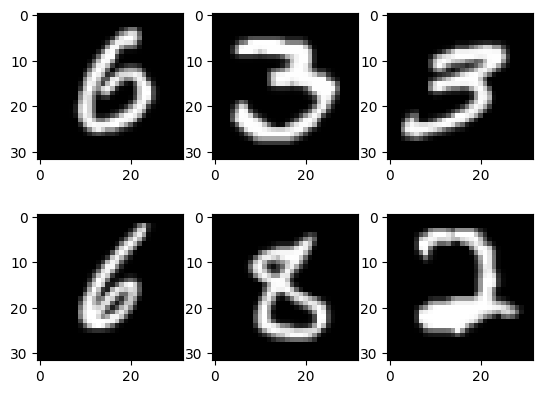

Predicted: "[6 3 3 6 8 2]", Actual: "[6 3 3 6 8 2]"


In [10]:
# ## 验证模型
#
# 我们使用生成的模型进行单个图片数据的分类预测，具体步骤如下：
#
# > - 被预测的图片会随机生成，每次运行结果可能会不一样。
# > - 代码使用了Tensor模块，阅读更多有关[张量Tensor](https://www.mindspore.cn/tutorials/zh-CN/r1.7/beginner/tensor.html)的信息。

import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

mnist = Mnist("./mnist", split="train", batch_size=6, resize=32)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

#图片输出
plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')


# 从上面的打印结果可以看出，预测值与目标值完全一致。Z
